# Jakub Mazur
nie oceniać

In [118]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt

from statsmodels.stats.oneway import effectsize_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer import FactorAnalyzer

import numpy as np

In [119]:
df = pd.read_csv('dane_zadanie_1.csv')
df

,ID,liczba sprzedanych produktów 2020,liczba sprzedanych produktów 2021,liczba sprzedanych produktów 2022,średnia prowizja 2020,średnia prowizja 2021,średnia prowizja 2022,kraj,płeć,sprzęt_komputerowy,oprogramowanie,wyposażenie_biura,organizacja_pracy,atmosfera,szkolenia,benefity,prowizje,płaca,zadowolenie
0,1,309,250,376,490,529,487,Francja,K,57.0,33.0,65.0,50.0,71.0,58.0,57.0,69.0,75.0,80
1,2,307,299,345,430,451,420,Niemcy,M,60.0,47.0,65.0,59.0,70.0,65.0,60.0,73.0,83.0,80
2,3,248,294,345,487,523,535,Niemcy,M,64.0,44.0,71.0,59.0,58.0,58.0,49.0,58.0,72.0,73
3,4,332,297,354,498,417,472,Francja,M,49.0,33.0,58.0,61.0,75.0,65.0,45.0,56.0,69.0,78
4,5,281,249,360,446,499,474,Francja,K,62.0,49.0,61.0,53.0,65.0,49.0,46.0,59.0,62.0,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,267,358,350,487,388,567,Francja,M,42.0,21.0,41.0,60.0,66.0,65.0,48.0,61.0,80.0,75
896,897,263,311,358,450,547,540,Niemcy,M,52.0,21.0,52.0,70.0,75.0,72.0,51.0,67.0,73.0,79
897,898,243,296,337,445,367,519,Francja,K,53.0,31.0,59.0,55.0,71.0,63.0,57.0,70.0,83.0,75
898,899,304,336,321,464,508,508,Hiszpania,M,45.0,27.0,47.0,46.0,78.0,51.0,46.0,54.0,65.0,72


In [120]:
lista_nazw_kolumn = df.columns.to_list()
lista_nazw_kolumn.remove('ID')
lista_nazw_kolumn.remove('kraj')
lista_nazw_kolumn.remove('płeć')

lista_nazw_kolumn.remove('liczba sprzedanych produktów 2020')
lista_nazw_kolumn.remove('liczba sprzedanych produktów 2021')
lista_nazw_kolumn.remove('liczba sprzedanych produktów 2022')

lista_nazw_kolumn.remove('średnia prowizja 2020')
lista_nazw_kolumn.remove('średnia prowizja 2021')
lista_nazw_kolumn.remove('średnia prowizja 2022')

lista_nazw_kolumn

['sprzęt_komputerowy',
 'oprogramowanie',
 'wyposażenie_biura',
 'organizacja_pracy',
 'atmosfera',
 'szkolenia',
 'benefity',
 'prowizje',
 'płaca',
 'zadowolenie']

In [121]:
df1 = pd.melt(df, value_vars=lista_nazw_kolumn)
df1 = df1.rename(columns={"variable": "group", "value": "score"})
df1.groupby('group')['score'].agg(['mean',  'median', 'std',  'skew', 'count']).round(2)

,mean,median,std,skew,count
group,,,,,
atmosfera,69.32,69.0,6.99,0.07,900
benefity,53.87,54.0,7.18,-0.01,900
oprogramowanie,34.54,34.0,8.21,0.11,900
organizacja_pracy,55.12,55.0,6.95,-0.03,900
prowizje,64.11,64.0,8.56,0.03,900
płaca,74.91,75.0,7.89,-0.02,900
sprzęt_komputerowy,53.59,53.5,7.41,-0.01,900
szkolenia,60.03,60.0,7.03,0.03,900
wyposażenie_biura,59.70,60.0,9.27,0.03,900


# Analiza czynnikowa




## 1. Normalność rozkładów
W pierwszej kolejności sprawdzamy normalność rozkładów.

**H0:** Rozkład jest normalny

**H1:** Rozkład nie jest normalny

Wszędzie gdzie pval < 0.05 odrzucamy H0 czyli rozkład nie jest normalny.

In [122]:
pg.normality(df1, group = 'group', dv = 'score')

,W,pval,normal
group,,,
sprzęt_komputerowy,0.996842,0.071871,True
oprogramowanie,0.996602,0.050213,True
wyposażenie_biura,0.997450,0.174793,True
organizacja_pracy,0.997022,0.093843,True
atmosfera,0.996879,0.075871,True
szkolenia,0.996628,0.052154,True
benefity,0.997098,0.104945,True
prowizje,0.996691,0.057315,True
płaca,0.997319,0.144916,True


Ze sprawdzenia wynika, że wszystkie rozkłady poza zadowoleniem mogą być normalne (nie odrzuciliśmy hipotezy zerowej).

## 2.Jednorodnoć wariancji

Hipotezy:

**H0:** Wariancje we wszystkich grupach są sobie równe.

**H1:** Wariancje dla conajmniej jednej pary wykonanych serii prób są różne: sigma_i =/= sigma_j

In [123]:
pg.homoscedasticity(df1, group='group', dv='score', method = 'bartlett')

,T,pval,equal_var
bartlett,348.226622,1.477696e-69,False


**ODP:** H0 jest odrzucone, rozkłady nie są takie same

## 3. Test sferyczności Barletta

Ma sprawdzić skorelowanie między zmiennymi

**H0:** Zmienne są ortogonalne (brak korelacji między zmiennymi).

**H1:** Zmienne nie są ortogonalne (istnieje korealacja między zmiennymi)

In [124]:
calculate_bartlett_sphericity(df[lista_nazw_kolumn])

(4400.8686996959705, 0.0)

p_value, czyli druga zwrócona wartość, wyszła na poziomie 0.0

Dlatego można odrzucić H0. H1, mówiące o tym że zmienne NIE są ortogonalne, świadczy o tym że zmienne SĄ skorelowane. Dlatego można wykonać analizę czynnikową.

## 4. Test KMO

In [125]:
kmo_all, kmo_model = calculate_kmo(df[lista_nazw_kolumn])
print(kmo_model)

0.6612406152872973


kmo wynosi 0.66, jest większe od 0.5. Oznacza to że zmienne są częściowo skorelowane, można przeprowadzić analizę czynnikową

## Określenie ilości faktorów

In [126]:
fa = FactorAnalyzer()

fa.fit(df[lista_nazw_kolumn])

ev, v = fa.get_eigenvalues()
ev

array([2.70332086, 2.26295591, 1.86370765, 0.99745435, 0.78306855,
       0.53186012, 0.329759  , 0.22665604, 0.19560463, 0.10561288])

In [127]:
values = np.arange(1, len(ev)+1)
values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

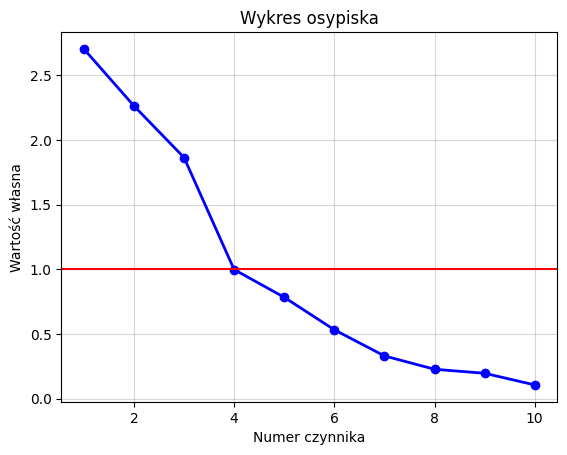

In [128]:
plt.plot(values, ev, 'o-', linewidth=2, color='blue')
plt.axhline(y = 1, color = 'r', label = 'axvline - full height')

plt.title('Wykres osypiska')
plt.xlabel('Numer czynnika')
plt.ylabel('Wartość własna')
plt.grid(alpha = 0.5)
plt.show()

Zgodnie z wykresem, wydaje się że 4 faktory będą optymalne

In [129]:
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit(df[lista_nazw_kolumn])
print(fa.loadings_)

[[ 9.79866650e-01  2.00174207e-02  4.36666817e-03  2.35436784e-03]
 [ 8.67416087e-01 -7.07766565e-04 -1.09943321e-02 -3.15778516e-03]
 [ 8.91634471e-01 -6.05817641e-03  2.95793915e-03  1.74150977e-02]
 [ 7.62265811e-02  2.74915853e-02  7.13272583e-01  8.45352427e-02]
 [ 6.74314108e-03  1.87282526e-02  2.11866589e-01  9.74537824e-01]
 [ 7.05467534e-02  8.86633697e-03  8.43496278e-01  2.63460478e-01]
 [ 1.24859679e-02  7.19334291e-01 -6.49202844e-03 -2.85516319e-02]
 [ 2.47662026e-02  1.00500937e+00 -2.79212576e-02  8.54351084e-03]
 [-7.10503041e-03  6.72060162e-01 -1.43546701e-02  4.55694957e-02]
 [-4.31680169e-02 -1.57557276e-02  6.47812481e-02 -1.35601646e-02]]


In [130]:
lmatrix = pd.DataFrame(fa.loadings_, index = list(df[lista_nazw_kolumn].columns), columns = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'])

# obliczenie wartości bezwzględnych

lmatrix = lmatrix.abs()
lmatrix

,Factor 1,Factor 2,Factor 3,Factor 4
sprzęt_komputerowy,0.979867,0.020017,0.004367,0.002354
oprogramowanie,0.867416,0.000708,0.010994,0.003158
wyposażenie_biura,0.891634,0.006058,0.002958,0.017415
organizacja_pracy,0.076227,0.027492,0.713273,0.084535
atmosfera,0.006743,0.018728,0.211867,0.974538
szkolenia,0.070547,0.008866,0.843496,0.263460
benefity,0.012486,0.719334,0.006492,0.028552
prowizje,0.024766,1.005009,0.027921,0.008544
płaca,0.007105,0.672060,0.014355,0.045569
zadowolenie,0.043168,0.015756,0.064781,0.013560


In [131]:
lmatrix.sort_values('Factor 1', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4
sprzęt_komputerowy,0.979867,0.020017,0.004367,0.002354
wyposażenie_biura,0.891634,0.006058,0.002958,0.017415
oprogramowanie,0.867416,0.000708,0.010994,0.003158
organizacja_pracy,0.076227,0.027492,0.713273,0.084535
szkolenia,0.070547,0.008866,0.843496,0.263460
zadowolenie,0.043168,0.015756,0.064781,0.013560
prowizje,0.024766,1.005009,0.027921,0.008544
benefity,0.012486,0.719334,0.006492,0.028552
płaca,0.007105,0.672060,0.014355,0.045569
atmosfera,0.006743,0.018728,0.211867,0.974538


Widać, że na Factor 1 olbrzymi wpływ mają:
* sprzęt_komputerowy
* wyposażenie_biura
* oprogramowanie

Można by powiedizeć że jest to factor związany ze stanowiskiem/ergonomią pracy

In [132]:
lmatrix.sort_values('Factor 2', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4
prowizje,0.024766,1.005009,0.027921,0.008544
benefity,0.012486,0.719334,0.006492,0.028552
płaca,0.007105,0.672060,0.014355,0.045569
organizacja_pracy,0.076227,0.027492,0.713273,0.084535
sprzęt_komputerowy,0.979867,0.020017,0.004367,0.002354
atmosfera,0.006743,0.018728,0.211867,0.974538
zadowolenie,0.043168,0.015756,0.064781,0.013560
szkolenia,0.070547,0.008866,0.843496,0.263460
wyposażenie_biura,0.891634,0.006058,0.002958,0.017415
oprogramowanie,0.867416,0.000708,0.010994,0.003158


Widać, że na Factor 2 olbrzymi wpływ mają:
* prowizje
* benefity
* płaca

Można by powiedizeć że jest to factor związany z bezpośrednimi i pośrednimi wpływami na konto pracownika

In [133]:
lmatrix.sort_values('Factor 3', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4
szkolenia,0.070547,0.008866,0.843496,0.263460
organizacja_pracy,0.076227,0.027492,0.713273,0.084535
atmosfera,0.006743,0.018728,0.211867,0.974538
zadowolenie,0.043168,0.015756,0.064781,0.013560
prowizje,0.024766,1.005009,0.027921,0.008544
płaca,0.007105,0.672060,0.014355,0.045569
oprogramowanie,0.867416,0.000708,0.010994,0.003158
benefity,0.012486,0.719334,0.006492,0.028552
sprzęt_komputerowy,0.979867,0.020017,0.004367,0.002354
wyposażenie_biura,0.891634,0.006058,0.002958,0.017415


Widać, że na facotr 3 olbrzymi wpływ mają:
* szkolenia
* organizacja pracy

Czyli można by pwoiedzieć że jest to factor związany z rozwojem pracowanika

In [134]:
lmatrix.sort_values('Factor 4', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4
atmosfera,0.006743,0.018728,0.211867,0.974538
szkolenia,0.070547,0.008866,0.843496,0.263460
organizacja_pracy,0.076227,0.027492,0.713273,0.084535
płaca,0.007105,0.672060,0.014355,0.045569
benefity,0.012486,0.719334,0.006492,0.028552
wyposażenie_biura,0.891634,0.006058,0.002958,0.017415
zadowolenie,0.043168,0.015756,0.064781,0.013560
prowizje,0.024766,1.005009,0.027921,0.008544
oprogramowanie,0.867416,0.000708,0.010994,0.003158
sprzęt_komputerowy,0.979867,0.020017,0.004367,0.002354


do ostatniego factora załapała się tylko atmosfera.

# Test Welcha
Dla danych wykorzystanych w Analizie Czynnikowej:
Ponieważ założenie o normalności rozkładów jest spełnione (poza zadowoleniem), a założenie o jednorodności wariancji nie jest, nie możemy zrobić testu Anovy, możemy natomiast zrobić test Welcha

**H0:** średnie są sobie równe (ale wariancje już niekoniecznie)

**H1:** conajmniej jedna średnia jest różna od pozostałych

In [135]:
pg.welch_anova(dv='score', between='group', data=df1)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,9,3657.797382,2715.4244,0.0,0.708088


Ponieważ p wynosi 0, wiadomo że któraś ze średnich różni się od pozostałych.

# Analiza post-hoc
## Test tukeya

**H0**: elementy mają taką samą średnią

**H1**: średnia elementów się różni

Czyli dla elementów gdzie p>0.5, kolumna reject będzie wynosi False, czyli nie można odrzucić hipotezy H0, czyli elementy mogą mieć taką samą średnią.

In [136]:
tukey = pairwise_tukeyhsd(endog=df1['score'],  groups=df1['group'], alpha=0.05)
print(tukey)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1             group2       meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------
         atmosfera           benefity -15.4522    0.0 -16.5784 -14.3261   True
         atmosfera     oprogramowanie -34.7833    0.0 -35.9095 -33.6572   True
         atmosfera  organizacja_pracy -14.2033    0.0 -15.3295 -13.0772   True
         atmosfera           prowizje    -5.21    0.0  -6.3362  -4.0838   True
         atmosfera              płaca   5.5856    0.0   4.4594   6.7117   True
         atmosfera sprzęt_komputerowy -15.7322    0.0 -16.8584 -14.6061   True
         atmosfera          szkolenia  -9.2889    0.0 -10.4151  -8.1627   True
         atmosfera  wyposażenie_biura    -9.62    0.0 -10.7462  -8.4938   True
         atmosfera        zadowolenie   8.1333    0.0   7.0072   9.2595   True
          benefity     oprogramowanie -19.3311    0.

* benefity i sprzęt_komputerowy
* szkolenia i wyposażenie_biura

to kolumny, które parami mogą mieć taką samą średnią, hipoteza zerowa dla tych par nie została odrzucona

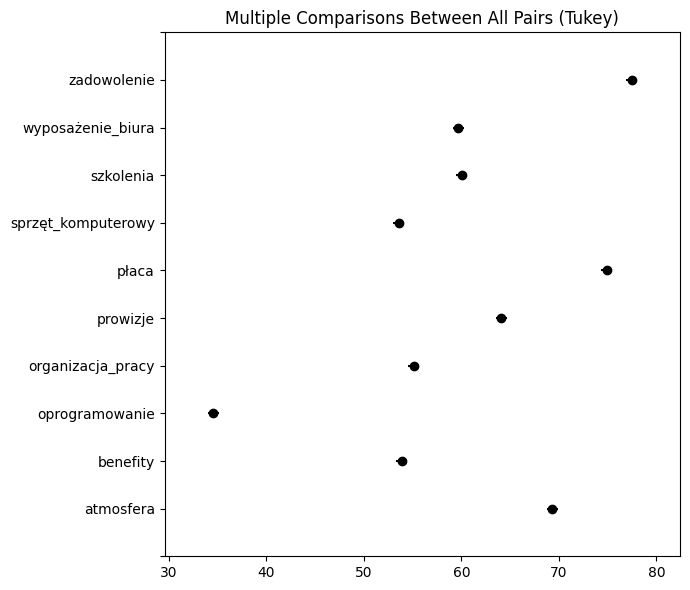

In [137]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
tukey.plot_simultaneous(ax=ax,figsize=(7, 6))
ax.vlines(x=0,ymin=-0.5,ymax=4.5, color="red")
fig.tight_layout()

Widać to faktycznie na wykresie, wyposażenie biura ma bardzo zbliżoną średnią do szkoleń, a sprzęt do benefitów.

## Moc efektu

moc efektu można odczytać bezpośrednio z testu Welcha, np2 ~= 0.7. Natomiast można także ją policzyć:

In [138]:
assumption = pd.DataFrame({'means':[np.mean(df[i]) for i in lista_nazw_kolumn], 'variances': [np.var(df[i]) for i in lista_nazw_kolumn], 'n': [len(df)]*len(lista_nazw_kolumn)})
assumption

,means,variances,n
0,53.590000,54.859678,900
1,34.538889,67.252932,900
2,59.702222,85.753551,900
3,55.118889,48.302532,900
4,69.322222,48.745062,900
5,60.033333,49.356667,900
6,53.870000,51.453100,900
7,64.112222,73.232962,900
8,74.907778,62.137051,900
9,77.455556,28.185802,900


In [139]:
effect = effectsize_oneway(means = assumption.means,
                  vars_ = assumption.variances,
                  nobs = assumption.n,
                  use_var = 'unequal')

print('wielkość efektu: ',effect)

power = FTestAnovaPower().power(effect_size = effect, nobs = len(df), alpha=0.05, k_groups=len(lista_nazw_kolumn))
print('moc testu: ', power)

wielkość efektu:  2.722408583915243
moc testu:  1.0


Wielkość efektu wyszła na poziomie 2.72, co oznacza że efekt jest bardzo silny (więcej niż 0.35)

# Anova dla innych danych

In [140]:
df

,ID,liczba sprzedanych produktów 2020,liczba sprzedanych produktów 2021,liczba sprzedanych produktów 2022,średnia prowizja 2020,średnia prowizja 2021,średnia prowizja 2022,kraj,płeć,sprzęt_komputerowy,oprogramowanie,wyposażenie_biura,organizacja_pracy,atmosfera,szkolenia,benefity,prowizje,płaca,zadowolenie
0,1,309,250,376,490,529,487,Francja,K,57.0,33.0,65.0,50.0,71.0,58.0,57.0,69.0,75.0,80
1,2,307,299,345,430,451,420,Niemcy,M,60.0,47.0,65.0,59.0,70.0,65.0,60.0,73.0,83.0,80
2,3,248,294,345,487,523,535,Niemcy,M,64.0,44.0,71.0,59.0,58.0,58.0,49.0,58.0,72.0,73
3,4,332,297,354,498,417,472,Francja,M,49.0,33.0,58.0,61.0,75.0,65.0,45.0,56.0,69.0,78
4,5,281,249,360,446,499,474,Francja,K,62.0,49.0,61.0,53.0,65.0,49.0,46.0,59.0,62.0,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,267,358,350,487,388,567,Francja,M,42.0,21.0,41.0,60.0,66.0,65.0,48.0,61.0,80.0,75
896,897,263,311,358,450,547,540,Niemcy,M,52.0,21.0,52.0,70.0,75.0,72.0,51.0,67.0,73.0,79
897,898,243,296,337,445,367,519,Francja,K,53.0,31.0,59.0,55.0,71.0,63.0,57.0,70.0,83.0,75
898,899,304,336,321,464,508,508,Hiszpania,M,45.0,27.0,47.0,46.0,78.0,51.0,46.0,54.0,65.0,72


In [141]:
lista_nazw_kolumn = ["średnia prowizja 2020", "średnia prowizja 2021", "średnia prowizja 2022", "liczba sprzedanych produktów 2020", "liczba sprzedanych produktów 2021", "liczba sprzedanych produktów 2022"]

In [142]:
df1 = pd.melt(df, value_vars=lista_nazw_kolumn)
df1 = df1.rename(columns={"variable": "group", "value": "score"})
df1.groupby('group')['score'].agg(['mean',  'median', 'std',  'skew', 'count']).round(2)

,mean,median,std,skew,count
group,,,,,
liczba sprzedanych produktów 2020,294.53,295.0,29.91,-0.00,900
liczba sprzedanych produktów 2021,299.43,299.0,25.59,0.11,900
liczba sprzedanych produktów 2022,341.87,342.0,15.41,-0.06,900
średnia prowizja 2020,457.54,456.5,54.60,0.04,900
średnia prowizja 2021,460.19,459.0,56.21,0.08,900
średnia prowizja 2022,498.87,499.0,55.06,-0.08,900


In [144]:
pg.normality(df1, group = 'group', dv = 'score')

,W,pval,normal
group,,,
średnia prowizja 2020,0.998694,0.762744,True
średnia prowizja 2021,0.999168,0.966141,True
średnia prowizja 2022,0.998756,0.798326,True
liczba sprzedanych produktów 2020,0.996959,0.085515,True
liczba sprzedanych produktów 2021,0.997769,0.272334,True
liczba sprzedanych produktów 2022,0.997754,0.266946,True


In [145]:
pg.homoscedasticity(df1, group='group', dv='score', method = 'bartlett')

,T,pval,equal_var
bartlett,2008.4312,0.0,False


Rozkłądy nie są normalne i wariancje dla co najmniej jednej próby są różne.

In [143]:
pg.welch_anova(dv='score', between='group', data=df1)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,5,2409.942735,4008.205899,0.0,0.78906
